In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%run ../init.py

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
import pickle
from sqlalchemy import  or_, and_,any_

In [ ]:
import re
from io import StringIO

def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)


In [5]:
with open('../candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    cands = pickle.load(f)

# Drop the unmapped labels

In [7]:
for k in range (3):
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, REGULATOR.gold_labels.any())).count()
    print session.query(REGULATOR).filter(and_(REGULATOR.split == k, ~REGULATOR.gold_labels.any())).count()

12987
0
3230
0
8335
0


## Load & balance dataset

In [8]:
from snorkel.annotations import load_gold_labels,load_marginals

In [9]:
from snorkel.annotations import load_marginals

train_cands  = session.query(REGULATOR).filter(REGULATOR.split == 0).all()
val_cands  = session.query(REGULATOR).filter(REGULATOR.split == 1).all()
test_cands  = session.query(REGULATOR).filter(REGULATOR.split == 2).all()
unlab_cands = session.query(REGULATOR).filter(REGULATOR.split == 3).all()

# train_marginals = load_marginals(session, split=0)
# # val_marginals = load_marginals(session, split=1)
# # test_marginals = load_marginals(session, split=2)
# # unlab_marginals = load_marginals(session, split=3)

# # L_gold_train = load_gold_labels(session, annotator_name='gold', split=0, load_as_array=True, zero_one=True)
L_gold_train  = load_gold_labels(session, annotator_name='gold', split=0, load_as_array=True, zero_one=True)
L_gold_val  = load_gold_labels(session, annotator_name='gold', split=1, load_as_array=True, zero_one=True)
# L_gold_test = load_gold_labels(session, annotator_name='gold', split=2, load_as_array=True, zero_one=True)

In [10]:
# also copied in ../MLutils.py

from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

def balance_candidates(cands, marginals, rs = 42):
    """Balance and shuffle candidates along with their (prob) labels.
    
    cands: list of candidate objects
    marginals: list of marginal (or not) labels
    rs: int: random_state (used in RandomUnderSampler and sklearn.utils.shuffle) 
    """
    rus = RandomUnderSampler(random_state=rs,return_indices=True)
    marginals_01 = np.round(marginals)

    _,_, indices = rus.fit_sample(pd.DataFrame(marginals), np.round(marginals))

    # shuffle indices
    indices = shuffle(indices, random_state = rs)

    # keep only selected items
    cands_us = [cands[i] for i in indices]
    marginals_us = [marginals[i] for i in indices]
    
    return cands_us, np.array(marginals_us)

In [11]:
train_cands_us, train_labels_us = balance_candidates(train_cands,L_gold_train)

# LSTM training

In [13]:
from snorkel.learning import GridSearch
from snorkel.learning import reRNN

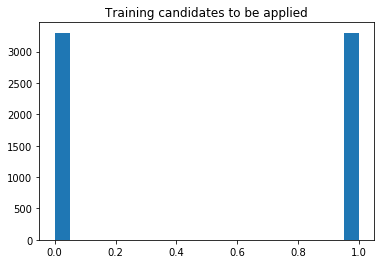

In [14]:
import matplotlib.pyplot as plt
plt.hist(train_labels_us, bins=20)
plt.title('Training candidates to be applied')
plt.show()

In [15]:

#    dropout  batch_size  n_epochs     lr  max_sentence_length  rebalance  \
# 2     0.25          32        20  0.001                  128       0.25   
# 8     0.25          32         5  0.001                   64       0.25

In [16]:
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   8,
    'dropout':    0.25,
    'rebalance':  0,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

lstm = reRNN(seed=1701, n_threads=None,)
lstm.train(train_cands_us, train_labels_us, X_dev = val_cands , Y_dev = L_gold_val, **train_kwargs)

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 40 has argument past max length for model:	[arg ends at index 66; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 148 has argument past max length for model:	[arg ends at index 67; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 202 has argument past max length for model:	[arg ends at index 66; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 219 has argument past max length for model:	[arg ends at index 94; max len 64]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorke

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6604  #epochs=8  batch size=32
[reRNN] Epoch 0 (13.22s)	Average loss=0.571305	Dev F1=50.76
[reRNN] Epoch 1 (27.76s)	Average loss=0.396966	Dev F1=50.00
[reRNN] Epoch 2 (42.17s)	Average loss=0.315530	Dev F1=51.39
[reRNN] Epoch 3 (57.90s)	Average loss=0.254488	Dev F1=53.48
[reRNN] Epoch 4 (73.45s)	Average loss=0.202535	Dev F1=53.95
[reRNN] Epoch 5 (91.34s)	Average loss=0.158589	Dev F1=53.15
[reRNN] Epoch 6 (105.88s)	Average loss=0.124446	Dev F1=53.05
[reRNN] Epoch 7 (120.37s)	Average loss=0.098341	Dev F1=52.10
[reRNN] Model saved as <reRNN>
[reRNN] Training done (122.43s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-7
[reRNN] Loaded model <reRNN>


# Evaluate on val/test

In [ ]:
# def print_pos_prf(tp,fp,tn,fn):
#     prec = (1.0*tp/(tp+fp))
#     rec = (1.0*tp/ (tp+fn))
#     f1 = (2*prec*rec)/float(prec+rec)
#     print "Precision (+):\t %.2f \nRecall (+):\t %.2f \nF1 score (+):\t %.2f \n"%(prec,rec, f1)

In [ ]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, L_gold_val)

## Determine sentence length statistics (for LSTM hidden units)

In [ ]:
def get_sentence_length(candidate):
    """Get sentence length of a certain candidate"""
    return len(candidate.get_parent().entity_types)

In [ ]:
lengths = pd.Series(list(map(lambda x: get_sentence_length(x),train_cands)))
plt.title("Sentence length histogram (words)")

# Grid Search

In [ ]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

In [ ]:
from snorkel.learning import RandomSearch, GridSearch
from snorkel.learning import SparseLogisticRegression

seed = 1234
num_model_search = 10

# search over this parameter grid
param_grid = {}
# param_grid['batch_size'] = [32, 64]
# param_grid['lr']         = [1e-3, 1e-2]
# param_grid['dropout'] = [0.25,0.5]
# param_grid['rebalance']  = [0.0, 0.25]

param_grid['max_sentence_length']  = [32, 64, 128]

param_grid['batch_size'] = [32]
param_grid['lr']         = [1e-3]
param_grid['dropout'] = [0.25]
param_grid['rebalance']  = [0.0, 0.25]
param_grid['n_epochs'] = [5,10,20]


model_hyperparams = {
#     'n_epochs': 20,
    'print_freq': 5,
    'dev_ckpt_delay': 0.5,
    'X_dev': val_cands,
    'Y_dev': L_gold_val
}

model_class_params = {
    'seed': seed,
    'n_threads':1
}

# Undersampling
searcher = RandomSearch(reRNN, param_grid, train_cands_us, train_marginals_us,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

In [ ]:
print "Discriminitive Model Parameter Space (seed={}):".format(seed)
for i, params in enumerate(searcher.search_space()):
    print i, params

disc_model, run_stats = searcher.fit(X_valid=val_cands, Y_valid=L_gold_val, n_threads=1)
print run_stats

# Predict on val & unlab 

In [ ]:
import pickle

In [ ]:
with open('../candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    cand_dict = pickle.load(f)

In [ ]:
# from snorkel.learning import reRNN

# lstm = reRNN(seed=1701, n_threads=None,)

In [ ]:
# # lstm.load(model_name='reRNN_14',save_dir="checkpoints/grid_search/")
# disc_model=lstm

In [17]:
cand_dict.keys()

NameError: name 'cand_dict' is not defined

# export results_dict

In [22]:
from sklearn.metrics import classification_report, f1_score

In [23]:
results_dict = {}

In [24]:
# # val_ground_truth = dict(map(lambda x: (x, cand_dict[1][x]['label']), cand_dict[1].keys()))
# val_ground_truth = list(map(lambda x: cand_dict[1][x]['label'], cand_dict[1].keys()))
# test_ground_truth = list(map(lambda x: cand_dict[2][x]['label'], cand_dict[2].keys()))

In [25]:
# Note: I also have L_gold_val, L_gold_test

In [26]:
cands.keys()

[0, 1, 2, 3]

In [41]:
## !!!!!!!!!!!! with lstm


# Validation
# val_pred = lstm.predictions(val_cands)
val_pred_prob = lstm.marginals(val_cands)
val_ids = list(map(lambda x: x.id ,val_cands))
# Test
# test_pred = lstm.predictions(test_cands)
test_pred_prob = lstm.marginals(test_cands)
test_ids = list(map(lambda x: x.id ,test_cands))
# Unlabelled
# unlab_pred = lstm.predictions(unlab_cands)
unlab_pred_prob = lstm.marginals(unlab_cands)
unlab_ids = list(map(lambda x: x.id ,unlab_cands))

# do it with 
val_ground_truth = list(map(lambda x: cands[1][x]['label'], val_ids))
test_ground_truth = list(map(lambda x: cands[2][x]['label'], test_ids))

class_report = report_to_df(classification_report(val_ground_truth, val_pred))

results_dict['biLSTM'] = {'label_val_prob+' :dict(zip(val_ids,val_pred_prob)),
                          'label_test_prob+' :dict(zip(test_ids,test_pred_prob)),
                          'label_unlab_prob+' :dict(zip(unlab_ids,unlab_pred_prob)),
                          "classification_report": class_report,
                          'f1+': f1_score(val_ground_truth, val_pred)
                         }

In [42]:
results_dict.keys()

['biLSTM']

In [43]:
with open('../ml_predictions/RuS,lr=0.001,dropout=0.25,8epochs,rebalance=0,max_sent_length=64.pkl', 'wb') as f:
    pickle.dump(results_dict, f)